# What's the impact of COVID on Airbnb in Seattle?  
##### A data-based approach using Seattle Airbnb open data in 2016 and in 2020.

COVID-19 pandemic has dramaticly changed human life worldwide and has presented an unprecedented challenge to public health, economy, and the world of work [[1]](https://www.who.int/news/item/13-10-2020-impact-of-covid-19-on-people's-livelihoods-their-health-and-our-food-systems). In this case study, I would explore how this pandemic changes Airbnb platform, by comparing the Seattle Airbnb open data in 2016 and in 2020. 

Two subquestioms I try to answer are:
1. What's the average availability in each neighborhood, and how that changes before and after COVID?
2. How Airbnb prices change before and after COVID?

In [1]:
# Import necessary packages
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing

In [2]:
# Set the maximum rows and columns to display
pd.set_option("display.max_rows", 365)
pd.set_option("display.max_columns", 99)

The datasets I used here can be obtained from [Kaggle](https://www.kaggle.com/airbnb/seattle) and [Inside Airbnb](http://insideairbnb.com/get-the-data.html). The datasets are also uploaded in the repository.  
Notice the listings data I use for year 2020 is already an aggregated dataset, which is different from the listings dataset for 2016

In [3]:
# Read raw data into data variables. 
# You may change the directory in the quote of the following sentence
seattle_calendar = pd.read_csv('D:/Git/airbnb_seattle/datasets/calendar2016.csv')
seattle_listings = pd.read_csv('D:/Git/airbnb_seattle/datasets/listings2016.csv')
seattle2020_listings_agg = pd.read_csv('D:/Git/airbnb_seattle/datasets/listings2020_agg.csv')
seattle2020_calendar = pd.read_csv('D:/Git/airbnb_seattle/datasets/calendar2020.csv')

### First question: What's the average yearly availability in each neighborhood, and how that changes in COVID?

Yearly availability is the number of days for which a particular home is available in a year.  
For example, we could take a look at the availabilities in 2016. I first grouped the dataset by neighbourhoods, and then calculated the minimum, average, median, maximum, and the count of the yearly availability "availability_365" in each neighbourhood.  
After that, a boxplot of "availability_365" for all neighbourhoods is presented.

In [4]:
neigh_grp = seattle_listings.groupby('neighbourhood_group_cleansed')
neigh_grp_sort = neigh_grp['availability_365'].agg(['min', 'mean', 'median', 'max', 'count']).sort_values(['mean'], ascending=False)
neigh_grp_sort

,min,mean,median,max,count
neighbourhood_group_cleansed,,,,,
Interbay,89,308.545455,365.0,365,11
Magnolia,2,282.754098,352.0,365,61
Lake City,0,280.611940,343.0,365,67
Delridge,0,272.721519,335.0,365,79
University District,0,271.704918,345.5,365,122
Northgate,0,263.812500,332.0,365,80
Beacon Hill,0,256.525424,323.5,365,118
West Seattle,0,255.911330,327.0,365,203
Ballard,0,252.673913,308.0,365,230


Text(0.5, 1.0, 'Availability in each Neighbourhood')

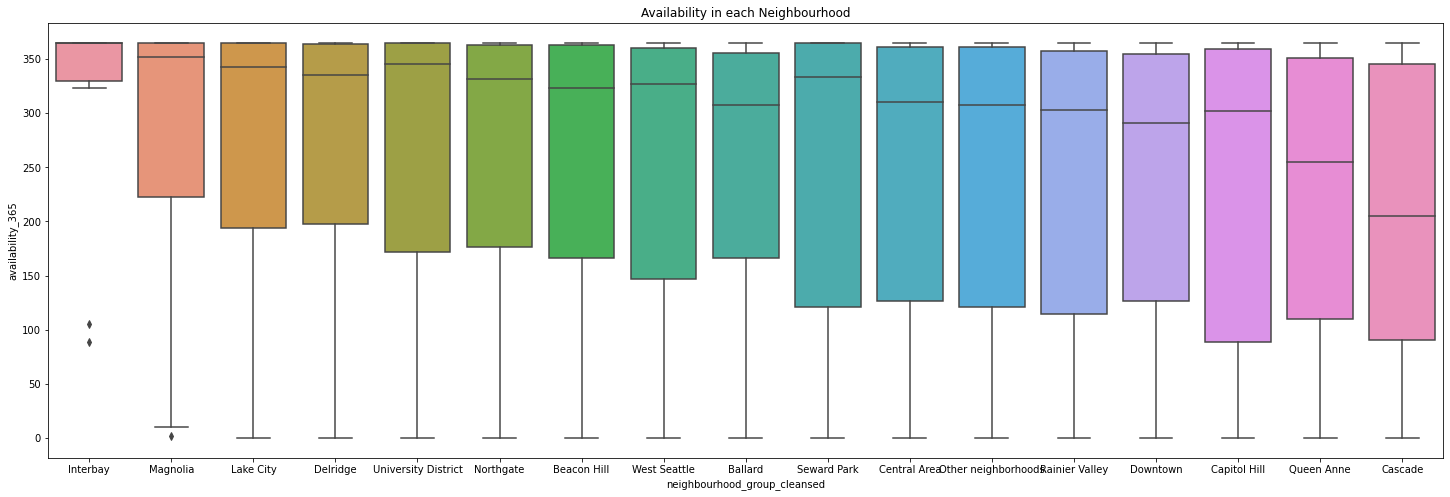

In [5]:
# Draw the boxplot of 
neigh_grp_sort = neigh_grp['availability_365'].agg(['min', 'mean', 'median', 'max', 'count']).sort_values(['mean'], ascending=False).index
df_sort = pd.DataFrame()
for i in neigh_grp_sort:
    df_sort = df_sort.append(pd.DataFrame(data = seattle_listings[seattle_listings['neighbourhood_group_cleansed'] == i]), ignore_index=True)
    
plt.figure(figsize=(25,8))
sns.boxplot(data = df_sort, x = 'neighbourhood_group_cleansed', y = 'availability_365')
plt.title('Availability in each Neighbourhood')

From the table and figure above, we could see that: 
- On average, Interbay, Magnolia, and Lack City are the top three heighbourhoods which have highest annual availabilities, while Cascade, Queen Anne, and Capitol Hill have lowest availabilities over a year. 
- Interbay has low variance of "availability_365."
- All the neighbourhoods has average number of available days larger than 200. 

I then take a look at the availability distribution for year 2020, which is when COVID and related policies might have impacts. I would like to draw similar boxplots for heighbourhood in year 2020 such that I could compare the distribution differences easily. To do that, I need to re-formulate the data.

In [6]:
# Create a dataset only with feature 'neighbourhood_group_cleaned,' 'availability_365,' 'price,' and 'year.'

# First, clean and process data of 2016
df_2016 = seattle_listings[['neighbourhood_group_cleansed', 'availability_365', 'price']]
df_2016 = df_2016.assign(year = [2016 for _ in range(df_2016.shape[0])])
df_2016 = df_2016.rename(columns={"neighbourhood_group_cleansed": "neighbourhood_group"})
df_2016.replace({'\$': '', '\%': '', '\,': ''}, regex = True, inplace = True)
df_2016['price'] = df_2016['price'].str.split('.', expand = True)[0]
df_2016['price'] = df_2016['price'].apply(pd.to_numeric)

# Then, clean and process data of 2020
df_2020 = seattle2020_listings_agg[['neighbourhood_group', 'availability_365', 'price']]
df_2020 = df_2020.assign(year = [2020 for _ in range(df_2020.shape[0])])

# Finally, merge two datasets together
df_year_merge = df_2016.append(pd.DataFrame(df_2020))
df_year_merge.dtypes

neighbourhood_group    object
availability_365        int64
price                   int64
year                    int64
dtype: object

Text(0.5, 0, 'Neighbourhood')

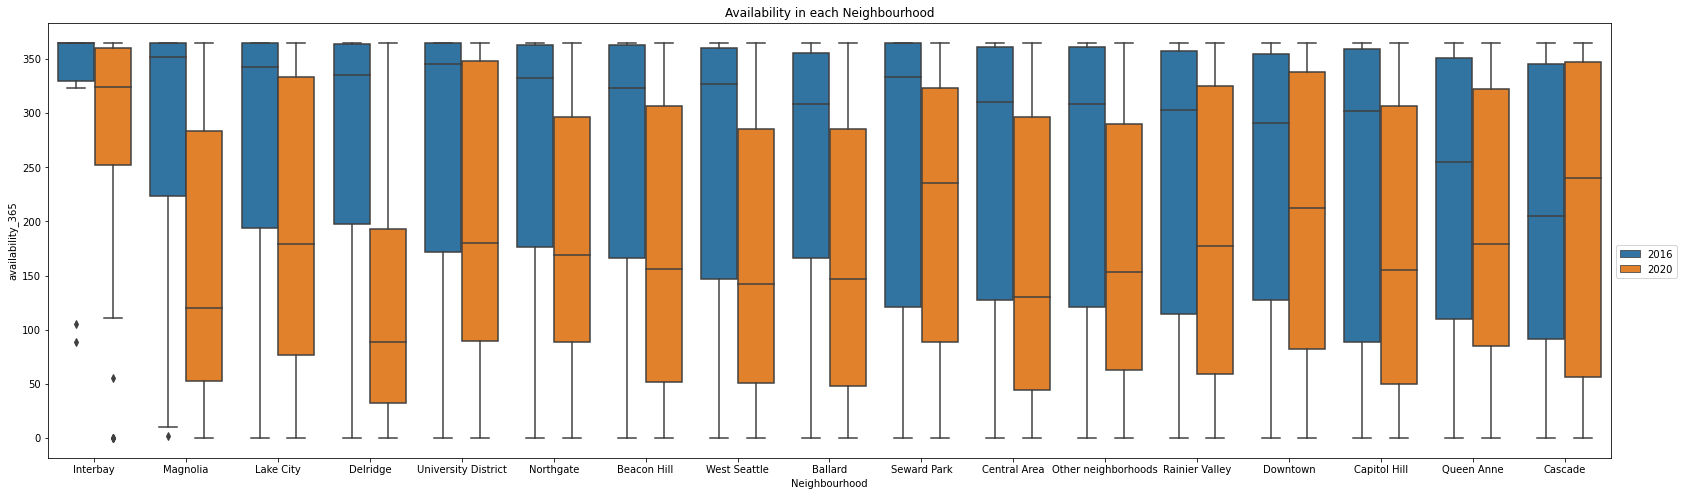

In [7]:
# Draw boxplots of two years in one figure
df_sort = pd.DataFrame()
for i in neigh_grp_sort:
    df_sort = df_sort.append(pd.DataFrame(data = df_year_merge[df_year_merge['neighbourhood_group'] == i]), ignore_index=True)
    
plt.figure(figsize=(28,8))
avail_plot = sns.boxplot(y='availability_365', x='neighbourhood_group', 
            data = df_sort, hue='year')
avail_plot.legend(loc='upper left', bbox_to_anchor=(1, 0.5), ncol=1)
plt.title('Availability in each Neighbourhood')
plt.xlabel('Neighbourhood')

We could observe from the boxplot that comparing with the availability distributions in 2016, Airbnb homes have significantly lower number of available days in 2020. 

### Second question: How Airbnb prices change in COVID?

Prices may impacted by a lot of factors such as time (different months), location (neighborhood), amenities, etc. In this section, I only explored the impacts of time (average price each month, and in two years). 

In [8]:
id_list = sorted(list(seattle_listings['id'].unique()))
def calendar_preprocessing(df, id_list = id_list):
    """
    This function processes original calendar dataset that is directly read from calendar.csv
        - replace the 'date' column with three columns
        - modify some of the numerical feature after data cleaning and processing
        - modify boolean features by replacing strings to T/F values

    input: 
        - df: the original dataset of calendar.csv
        - id_list: a list of Airbnb home ids
    output: 
        processed dataset of calendar
    """
    
    df.sort_values(by='listing_id', ascending=True, inplace = True)

    # split column 'date' into three columns: 'year', 'month', 'day'
    df[['year', 'month', 'day']] = df['date'].str.split('-', expand = True)
    df.drop(columns=['date'], inplace = True)
    
    # rerecode boolean column 
    df.replace('t', 1, inplace = True) 
    df.replace('f', 0, inplace = True) 
    
    # recode column 'available'
    df.replace({'\$': '', '\%': '', '\,': ''}, regex = True, inplace = True)
    df['price'] = df['price'].str.split('.', expand = True)[0]
    df[['price']] = df['price'].apply(pd.to_numeric)

    return df

seattle_calendar = calendar_preprocessing(seattle_calendar, id_list)

In [9]:
def monthly_price(df, id_list = id_list):
    """
    This function generate a dataframe of average monthly price for each Aibnb home from calendar dataset
            
    input: 
        - df: calendar.csv after preprocessing, i.e., the seattle_calendar dataframe obtained from the previous cell
    output: 
        a dataframe of average price for each Airbnb in each month
        - columns of the new dataframe: ['id', '01_price', '02_price', '03_price', '04_price', '05_price', '06_price', 
                                        '07_price', '08_price', '09_price', '10_price', '11_price', '12_price']
    """
          
    output = pd.DataFrame()
    output['id'] = id_list
    month_list = ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12']
    
    for month_iter in month_list:
        filt = df['month'] == month_iter
        id_grp = df.loc[filt, ].groupby('listing_id')
        output[month_iter + '_' + 'price'] = id_grp['price'].mean().to_list()

    return output

In [10]:
# Process and obtain the monthly price datasets for year 2020
id_list = sorted(list(seattle2020_calendar['listing_id'].unique()))
seattle2020_calendar = calendar_preprocessing(seattle2020_calendar, id_list)
monthly_price_df2020 = monthly_price(seattle2020_calendar, id_list)
monthly_price_df2020

,id,01_price,02_price,03_price,04_price,05_price,06_price,07_price,08_price,09_price,10_price,11_price,12_price
0,2318,296.0,296.000000,345.000000,350.000000,376.612903,475.000000,475.000000,475.000000,475.000000,296.0,296.0,296.0
1,9419,55.0,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000,55.0,55.0,55.0
2,9531,165.0,162.500000,165.000000,165.000000,175.000000,185.000000,165.000000,185.000000,177.333333,165.0,165.0,165.0
3,9534,125.0,125.000000,125.000000,125.000000,125.000000,125.000000,125.000000,125.000000,132.666667,125.0,125.0,125.0
4,9596,100.0,100.000000,100.000000,100.000000,100.064516,100.333333,100.000000,100.000000,100.000000,100.0,100.0,100.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4191,48245550,65.0,65.000000,65.000000,65.000000,65.000000,65.000000,65.000000,65.000000,65.000000,65.0,65.0,65.0
4192,48245563,66.0,66.000000,66.000000,66.000000,66.000000,66.000000,66.000000,66.000000,66.000000,66.0,66.0,66.0
4193,48255236,60.0,57.821429,55.516129,62.333333,71.903226,71.666667,72.225806,71.580645,61.866667,60.0,60.0,60.0
4194,48255748,186.0,186.000000,186.000000,186.000000,186.000000,186.000000,186.000000,186.000000,186.000000,186.0,186.0,186.0


In [11]:
# Process and obtain the monthly price datasets for year 2016
id_list = sorted(list(seattle_calendar['listing_id'].unique()))
monthly_price_df2016 = monthly_price(seattle_calendar, id_list)

I then plot the curves of the average prices for each month in year 2016 and 2020. From the curves we could observe that:
- In general, prices in summer time (Jun., Jul., Aug., Sep.) are higher than prices in winter time.  
- The average of prices in 2020 are higher than the prices in 2016 in every month. 

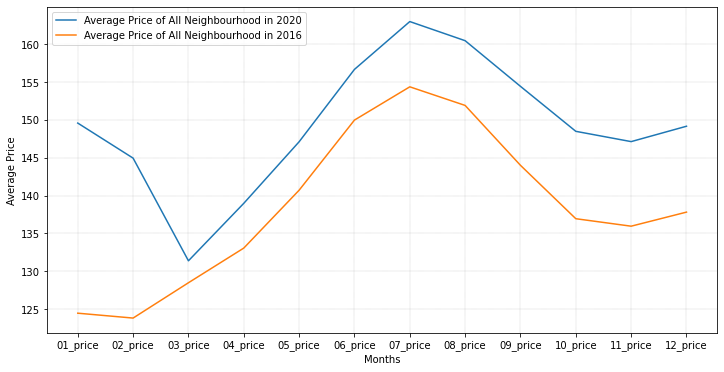

In [12]:
plt.subplots(figsize = (12,6))
plt.grid(linewidth = 0.2, linestyle='--', color='gray')
plt.plot(monthly_price_df2020.mean()[1:], label='Average Price of All Neighbourhood in 2020')
plt.plot(monthly_price_df2016.mean()[1:], label='Average Price of All Neighbourhood in 2016')
plt.ylabel('Average Price')
plt.xlabel('Months')
plt.legend()
plt.show()
